In [44]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import pandas as pd
import json
import re

from tqdm import tqdm
from collections import Counter
from random import sample
from scipy.optimize import curve_fit

from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

CUSTOM_FORMAT = {"with_labels" : False,
                "node_size": 10, "node_color": "red", "edgecolors": "black",
                "linewidths": 0.25, "width": 0.25, "edge_color": "black"}


# 1) Red Erdos Renyi $G(N, p)$

In [45]:
def erdos_renyi_graph(N: int, p: float) -> nx.Graph:
    """
    Red Erdos Renyi a partir de la cantidad de nodos N y la probabilidad de enlazarse p.
    """

    random_matrix = np.random.random((N, N)) #Matriz de NxN de numeros aleatorios del 0 al 1.
    #Si el valor obtenido es menor que p, nos quedamos.
    threshold = np.where(random_matrix < p, 1, 0) #Para un valor de p-pequeño: "Era poco probable, pero pasó."

    #Nos quedamos con la parte superior, la transpuesta de la misma, y la diagonal para armar una A simétrica.
    A = np.triu(threshold, 1) + np.triu(threshold, 1).T
    return nx.from_numpy_array(A)


def erdos_renyi_m(N: int, approx_m: int) -> nx.Graph:
    """
    Red Erdos Renyi a partir de la cantidad de nodos N y la cantidad de enlaces.
    """
    p = 2*approx_m/(N*(N-1))
    return erdos_renyi_graph(N, p)


## a)

In [46]:
N = 10_000
m = 50_000
iters = 200

#Esto puede demorar bastante.
try:
    with open("1a.list", "rb") as f:
        m_vals = pickle.load(f)
except FileNotFoundError:
    m_vals = [len(list(erdos_renyi_m(N, m).edges())) for i in tqdm(range(iters))]
    with open("1a.list", "wb") as f:
        pickle.dump(m_vals, f)

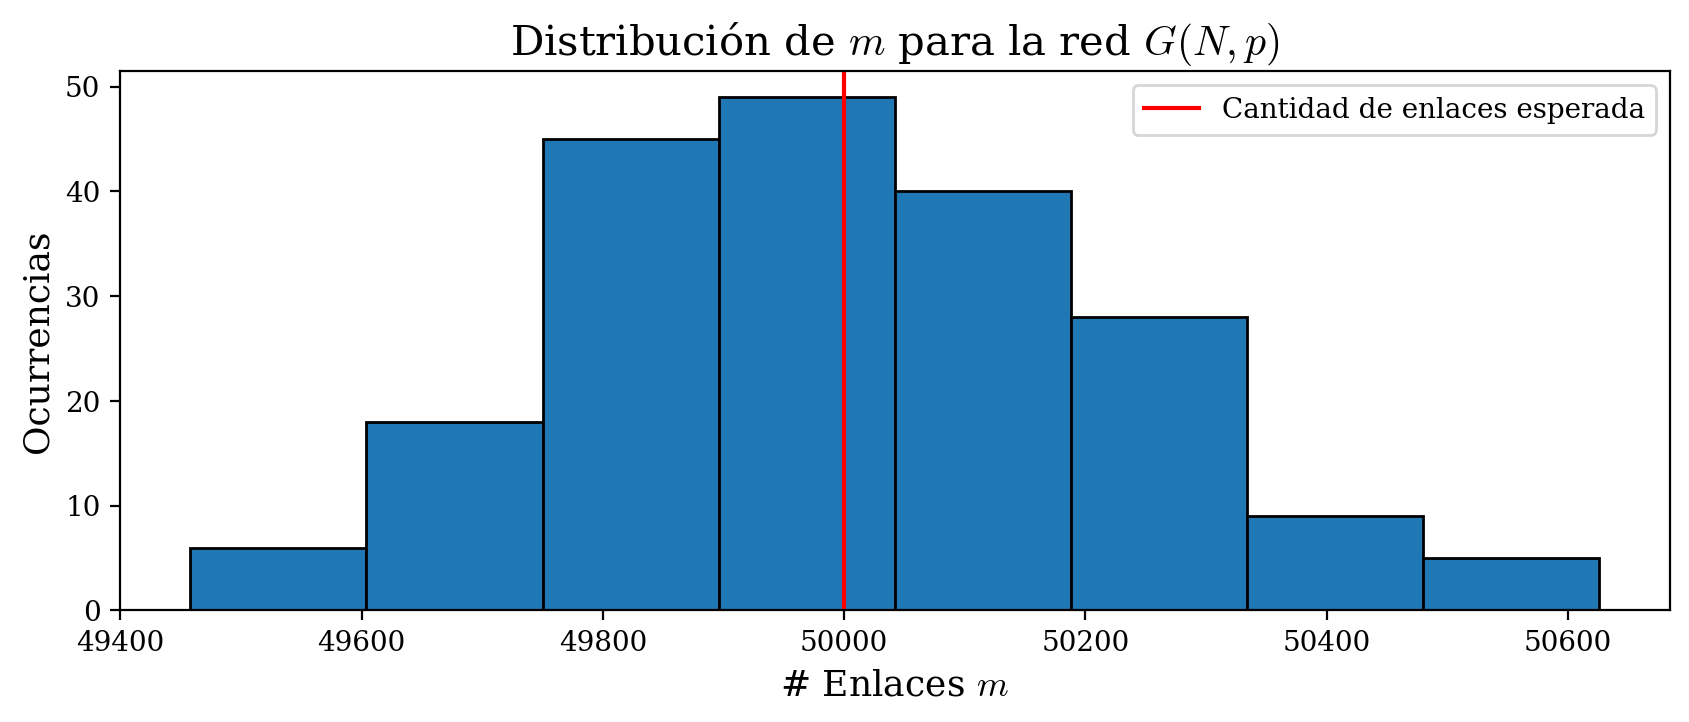

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

plt.hist(m_vals, bins=8, ec='k')
plt.axvline(m, color = "red", label="Cantidad de enlaces esperada")
plt.xlabel("# Enlaces $m$", fontsize=13)
plt.ylabel("Ocurrencias", fontsize=13)
plt.title("Distribución de $m$ para la red $G(N, p)$", fontsize=15)
plt.legend()
plt.show()

Al realizar 200 iteraciones de la red aleatoria Erdos renyi con 10000 nodos, 
guardando la cantidad de enlaces obtenidos por cada realización, observamos que
el m promedio obtenido coincide con el obtenido según la relación 
$m \approx p \frac{n (n-1)}{2}$. Esta relación se puede obtener si se considera
que la probabilidad p es uniforme (?) y la cantidad de enlaces totales posibles
es $\binom{n}{2} = \frac{n (n-1)}{2}$, por ende, la cantidad de enlaces obtenidos
considerando $n \to \infty$ será $m = p \frac{n (n-1)}{2}$.

## b)

In [50]:
N_arr = np.arange(100, 10_000, 500)
p = 0.001

try:
    with open("1b.list", "rb") as f:
        k_vals = pickle.load(f)

except FileNotFoundError:
    k_vals = []
    for N in tqdm(N_arr):
        G = erdos_renyi_graph(N, p)
        k_arr = list(dict(G.degree()).values())
        k_mean = np.mean(k_arr)
        k_vals.append(k_mean)

    with open("1b.list", "wb") as f:
        pickle.dump(k_vals, f)

Pendiente obtenida:  a = 0.001000095998038455 (Esperado: 0.001)
Ordenada al origen obtenida:  b = -0.03646517467416205 (Esperado: -0.001)


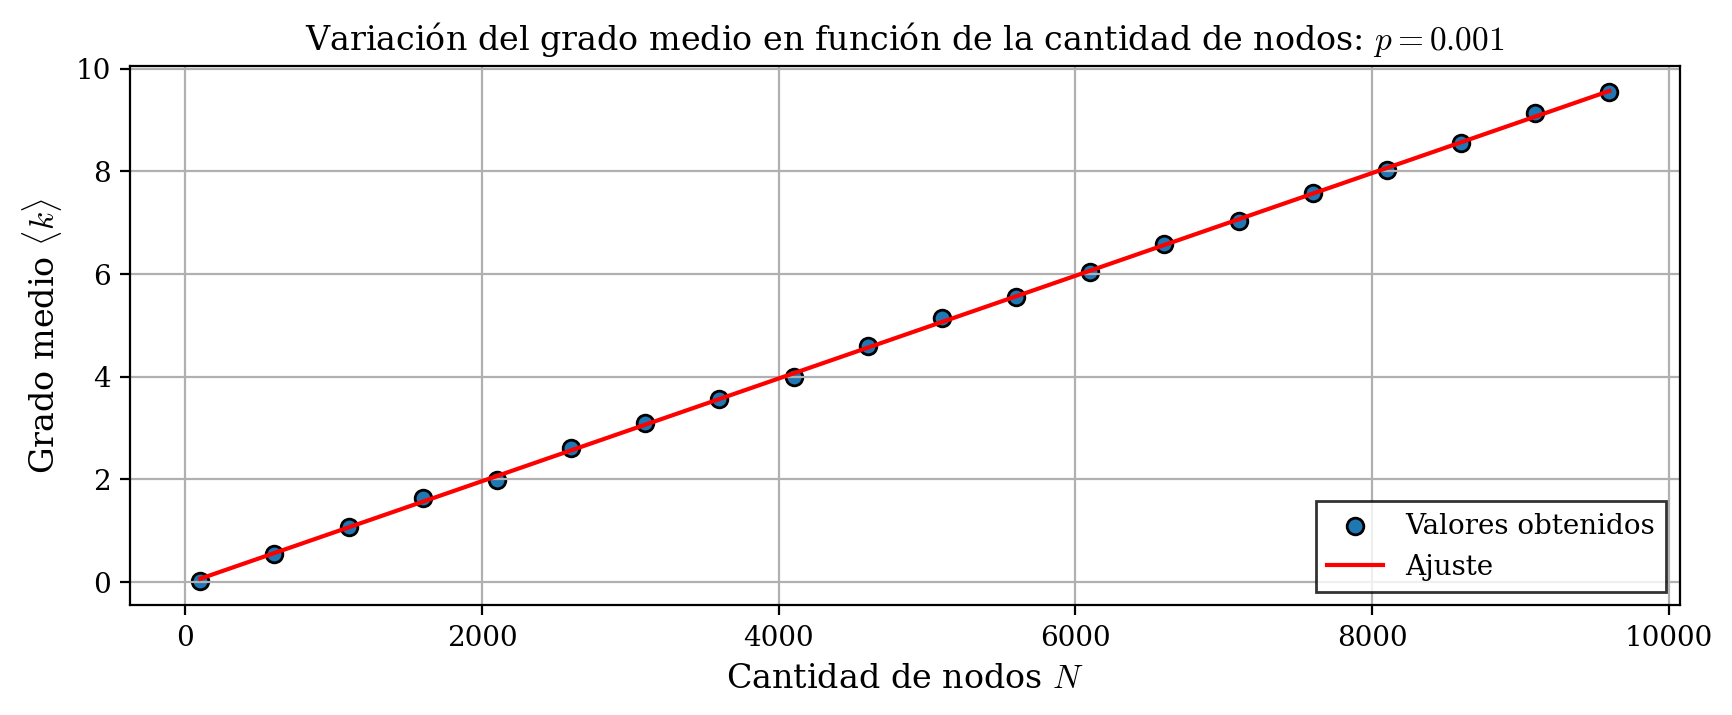

In [52]:
lineal = lambda x, a, b: a*x+b
popt, pcov = curve_fit(lineal, N_arr, k_vals)
a, b = popt

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

ax.scatter(N_arr, k_vals, ec = "black", label = "Valores obtenidos")
ax.plot(N_arr, lineal(N_arr, *popt), color="red", label="Ajuste")
ax.legend(loc="lower right", fancybox=False, edgecolor="black")
ax.set_xlabel("Cantidad de nodos $N$")
ax.set_ylabel(r"Grado medio $\langle k \rangle$")
ax.set_title(f"Variación del grado medio en función de la cantidad de nodos: ${p =}$")
ax.grid()

print(f"Pendiente obtenida: { a = } (Esperado: {p})")
print(f"Ordenada al origen obtenida: { b = } (Esperado: {-p})")

Como la suma de los grados es lo mismo que contar los extremos de cada enlace,
entonces $\sum^n k_i = 2 m \approx p n (n-1)$, entonces el grado medio es
$\frac{\sum^n k_i}{n} \approx p (n-1)$.

# 2) Red aleatoria $G(N, k_0)$

In [8]:
def random_k0_graph(n: int, k0: int) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
        
    nodes = list(range(k0+1))  # ids

    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)
    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        targets = sample(nodes, k0)
        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, t) for t in targets])

    return G

# 3) Red Barabasi $\hat{G}(N, k_0)$

In [53]:
def barabasi_graph(n: int, k0: int) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
    
    nodes = list(range(k0+1))  # ids

    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)

    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        rand_vec = np.random.random(len(nodes))
        #k_vec = nx.to_numpy_array(G)@np.ones_like(rand_vec)  # grado vector

        degrees = dict(G.degree())
        sorted_degrees = dict(sorted(degrees.items())) #Grados (ordenados).
        
        k_vec = np.array(list(sorted_degrees.values()))

        p_vec = k_vec/np.sum(k_vec)
        link_to = rand_vec < p_vec
        
        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, i) for i, t in enumerate(link_to) if t])

    return G

## a)

In [56]:
N = 10_000
k0_arr = range(5, 55, 5)
k0_arr = np.array(k0_arr)
#Esto puede demorar bastante.
try:
    with open("3a.list", "rb") as f:
        m_vals = pickle.load(f)

except FileNotFoundError:
    m_vals = []
    for k0 in tqdm(k0_arr):
        G = barabasi_graph(N, k0)
        m = len(list(G.edges()))
        m_vals.append(m)

    with open("3a.list", "wb") as f:
        pickle.dump(m_vals, f)

100%|██████████| 10/10 [03:03<00:00, 18.40s/it]


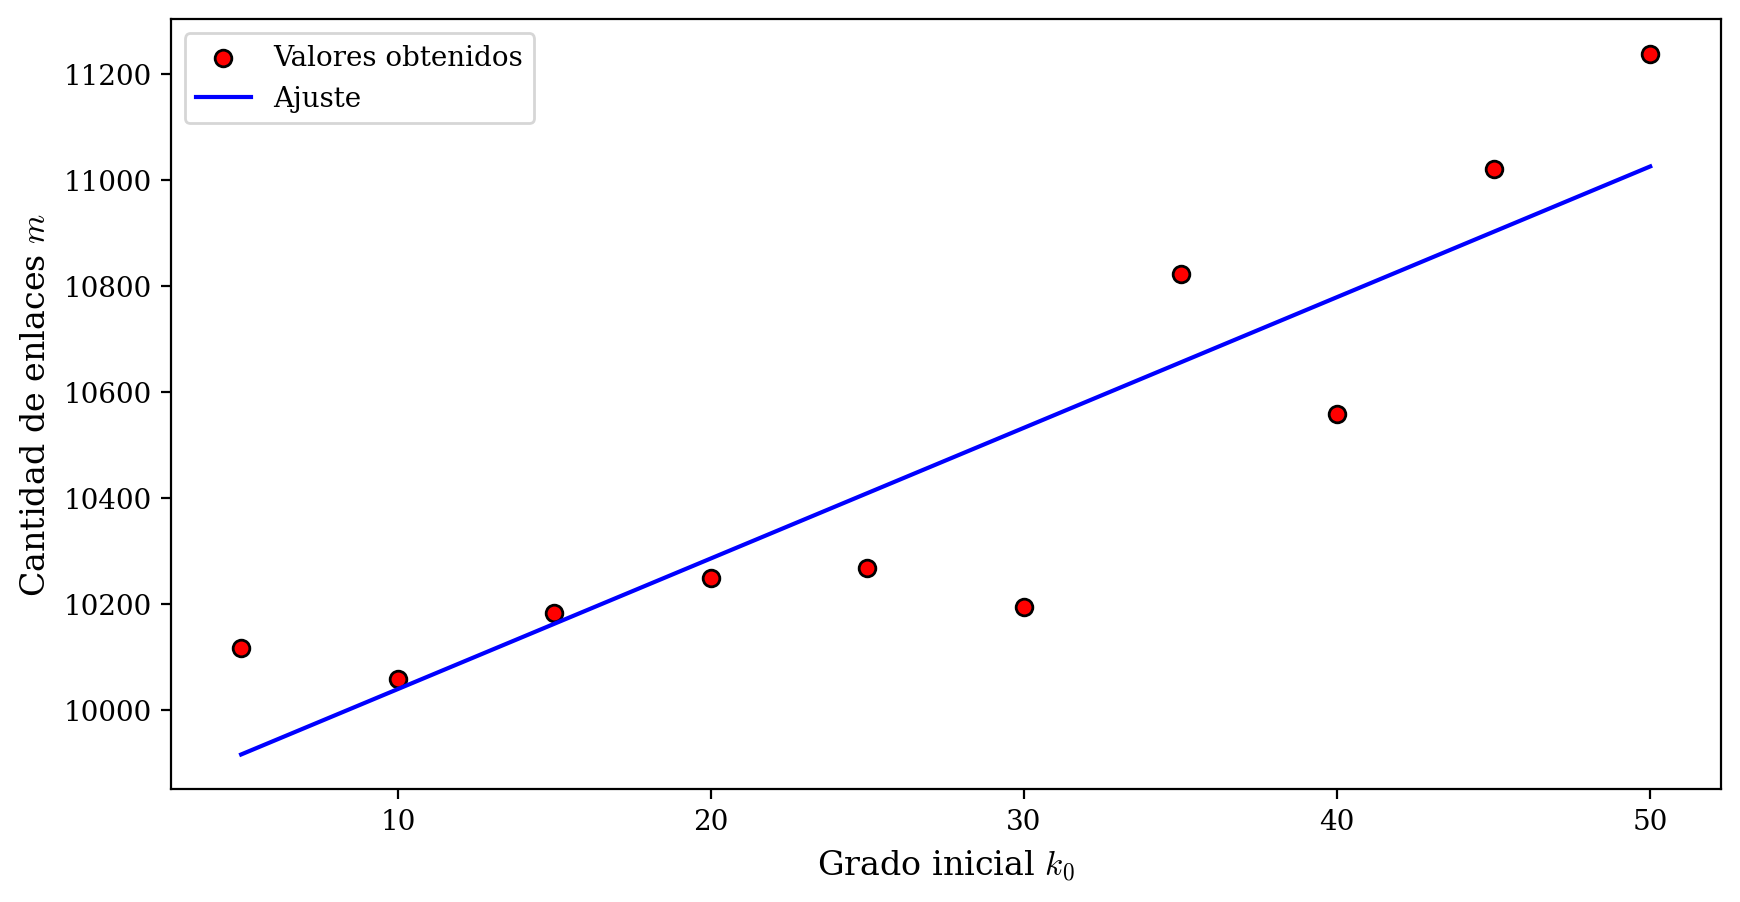

Pendiente obtenida: a = 24.649697098554324 (Esperado 10000)
Ordenada al origen obtenida: b = 9792.333329789755 (Esperado 0)


In [57]:
lineal = lambda x, a, b: a*x+b
popt, pcov = curve_fit(lineal, k0_arr, m_vals)
a, b = popt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.scatter(k0_arr, m_vals, color = "red", label = "Valores obtenidos", ec="black")
plt.plot(k0_arr, lineal(k0_arr, *popt), color="blue", label="Ajuste")
plt.xlabel("Grado inicial $k_0$")
plt.ylabel("Cantidad de enlaces $m$")
plt.legend()
plt.show()

print(f"Pendiente obtenida: {a = } (Esperado {N})")
print(f"Ordenada al origen obtenida: {b = } (Esperado 0)")

Los resultados del ajuste lineal al gráfico anterior corrobora la relación de $m \approx k_0 n$.
La expresión anterior para la cantidad de enlaces en función de $n$ y $k_0$ se
puede obtener de la siguiente manera;
Con el procedimiento realizado, si se calculan la cantidad de enlaces se puede ver
que para los $k_0+1$ nodos iniciales, la cantidad de enlaces iniciales será $m_0 = \frac{k_0 k_0+1}{2}$.
Luego, los enlaces al nuevo nodo se conectarán con probabilidad $p_i = \frac{k_i}{\sum_{j=0}^{k_0+1} k_j} = \frac{k_i}{2 m_0}$, y los enlaces nuevos serán $m_1 = p_i n_0 = \frac{k_i}{2 m_0} (k_0+1)$, 
pero como $k_i = k_0$ entonces m_1 = 1.

Para el último paso, se tendrá que $p_i = \frac{k_i}{2 m}$


100%|██████████| 2/2 [00:00<00:00, 675.47it/s]

5
10


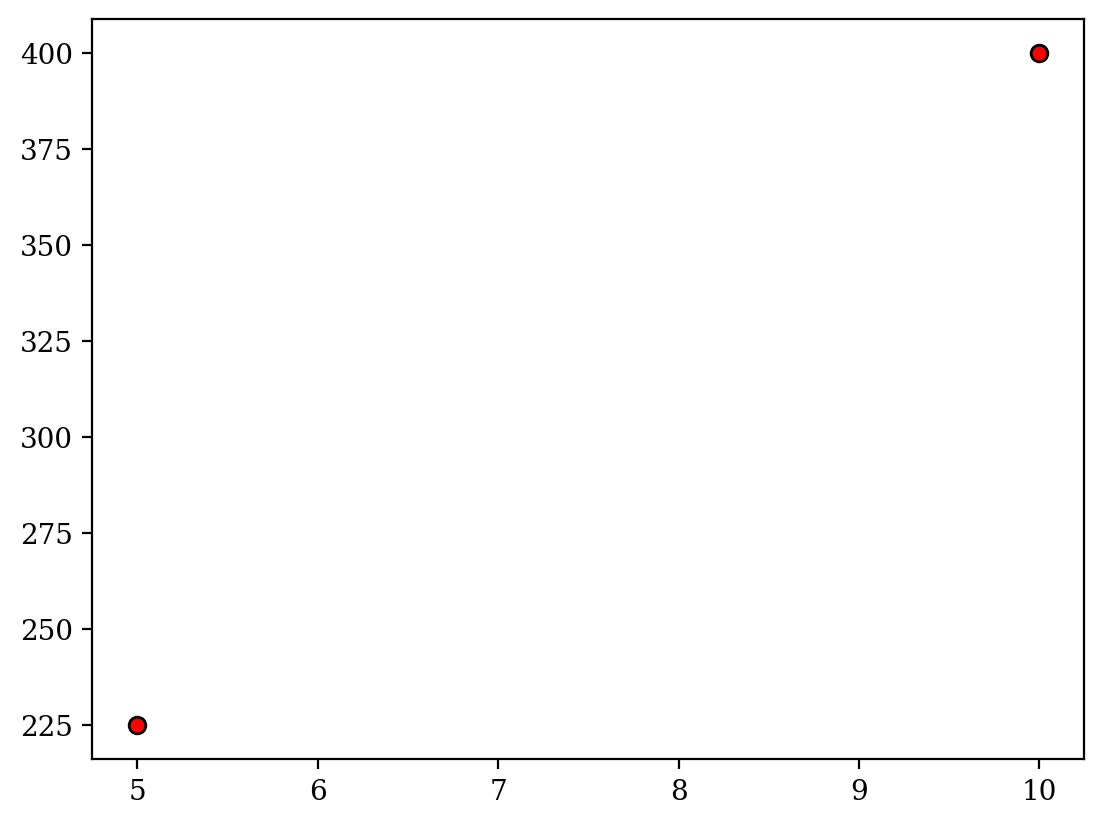

In [12]:
m_vals = []
for k0 in tqdm(k0_arr):
        print(k0)
        G = nx.barabasi_albert_graph(50, k0)
        m = len(list(G.edges()))
        m_vals.append(m)
plt.scatter(k0_arr, m_vals, color = "red", label = "Valores obtenidos", ec="black")

# 4)

In [13]:
def plot_degree_dist(G, ax = None):
    """
    Plot de la distribución de grados de este tipo de red.
    """

    degrees = dict(G.degree())
    degrees_dist = Counter(degrees.values())
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        plt.scatter(degrees_dist.keys(), degrees_dist.values(), ec="black")
        return fig, ax
    else:
        ax.scatter(degrees_dist.keys(), degrees_dist.values(), ec="black")

def plot_random_distributions(G: nx.Graph, k02: int = 5, k03: int = 5, suptitle = None):
    fig, ax = plt.subplots(1, 4, figsize=(12, 4))

    N = len(list(G.nodes()))
    m = len(list(G.edges()))

    G_random1 = erdos_renyi_m(N, m)
    G_random2 = random_k0_graph(N, k02)
    G_random3 = nx.barabasi_albert_graph(N , k03)

    #Distribución real
    plot_degree_dist(G, ax[0])
    plot_degree_dist(G_random1, ax[1])
    plot_degree_dist(G_random2, ax[2])
    plot_degree_dist(G_random3, ax[3])
    
    for i in range(4):
        ax[i].set_xlabel("Grado $k$")
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
    ax[0].set_ylabel("Ocurrencias")
    
    ax[0].set_title("Distribución real")
    ax[1].set_title("Erdos Renyi")
    ax[2].set_title("Random $k_0$")
    ax[3].set_title("Barabasi")

    fig.suptitle(suptitle)



In [14]:
df_science = pd.read_csv("datasets/netscience_edgelist.txt", delimiter=";", header=None, names=["source", "target", "reference"])
df_science["reference"] = df_science["reference"].apply(lambda x: re.sub("'", "\"", x)) #Movemos a formato de JSON estandar
df_science["reference"] = df_science["reference"].apply(json.loads).apply(pd.Series)    #Cargamos a json y desempaquetamos el dict con el Series.

df_y2h = pd.read_csv("datasets/yeast_Y2H.txt", delimiter="\t", header=None, names=["source", "target"])

df_internet = pd.read_csv("datasets/as-22july06_edgelist.txt", delimiter=" ", header=None, names=["source", "target", "val"])
df_internet.drop("val", axis=1, inplace=True)

dataframes = { 
    "Science": df_science,
    "Internet": df_internet,
    "Y2H": df_y2h,
}

### Creación de grafos
graph_science = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph())
graph_science_weighted = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph(), edge_attr = "reference")
weights_science = [i['reference'] for i in dict(graph_science_weighted.edges).values()]

graph_y2h = nx.from_pandas_edgelist(df_y2h,"source","target", create_using=nx.Graph())

graph_internet = nx.from_pandas_edgelist(df_internet,"source","target", create_using=nx.Graph())

dict_graph = { 
    "Science": graph_science,
    "Internet": graph_internet,
    "Y2H": graph_y2h,
}

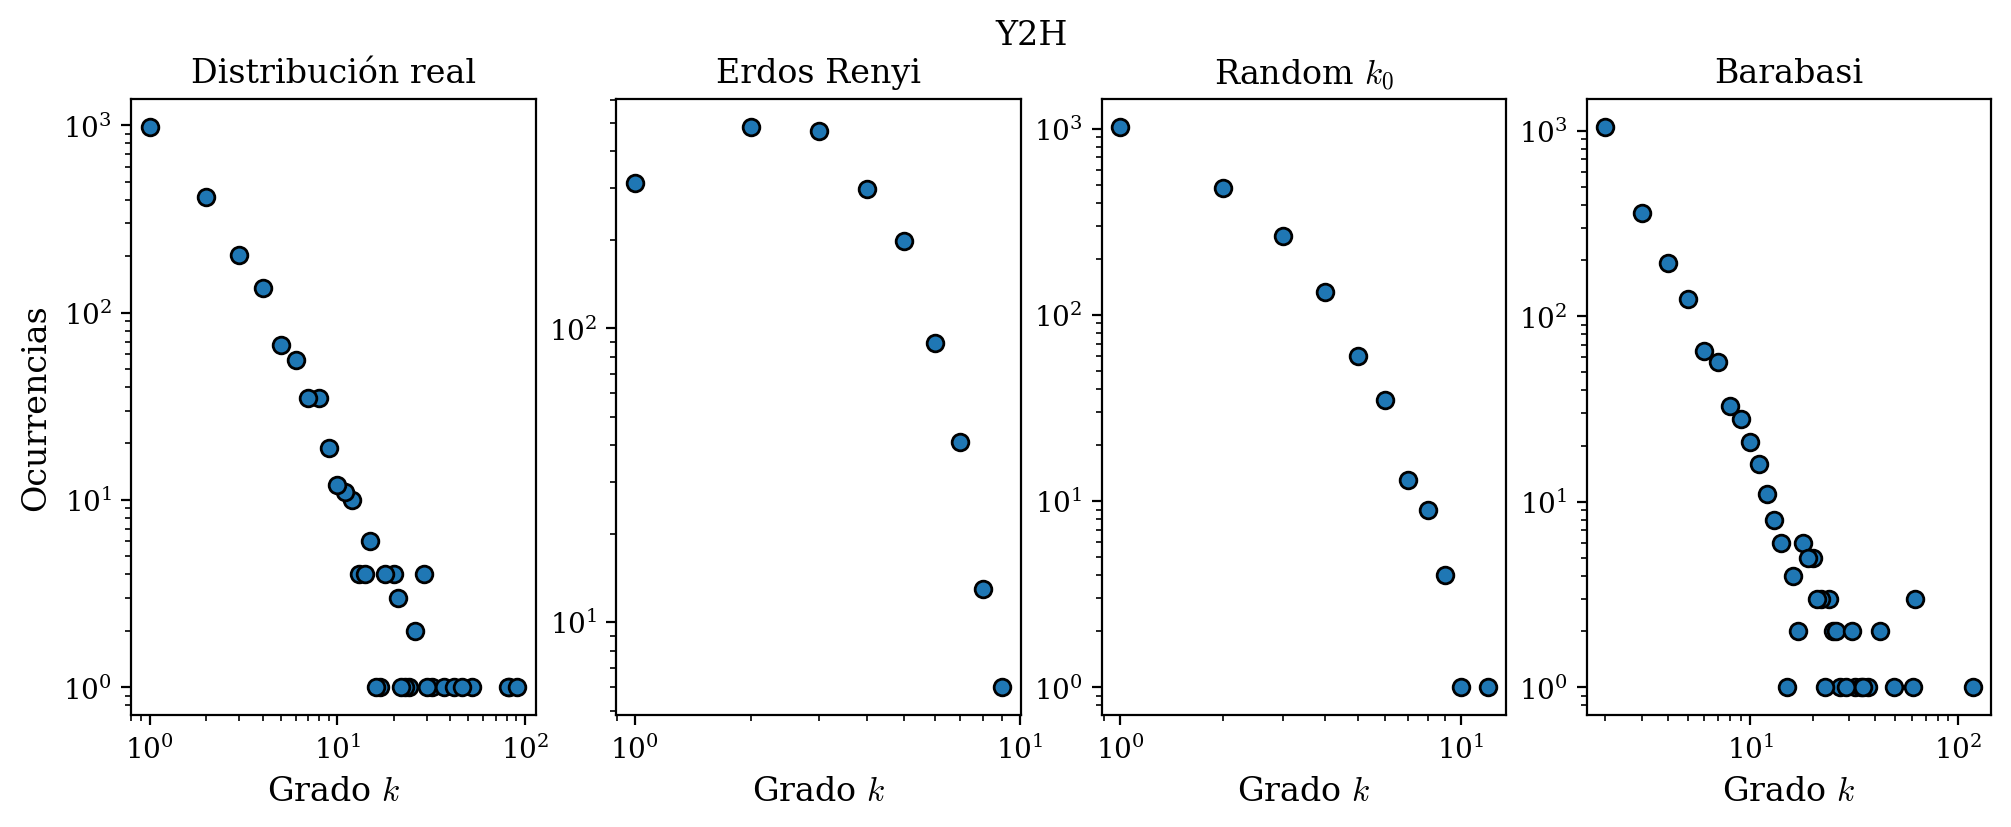

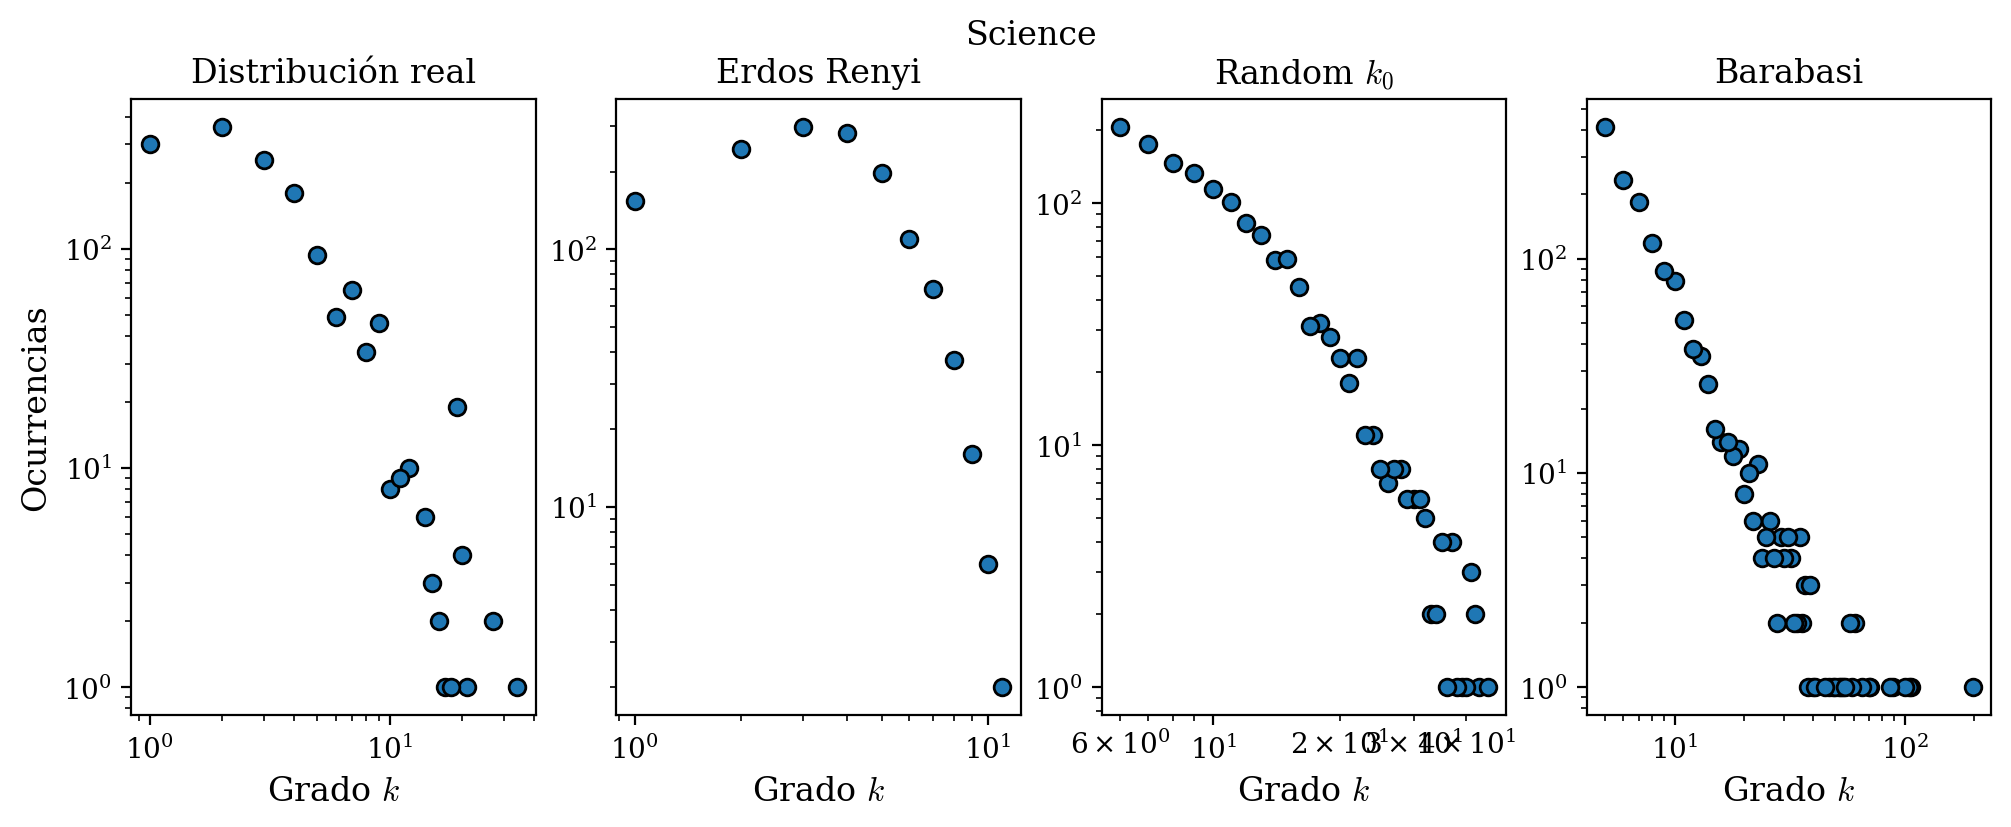

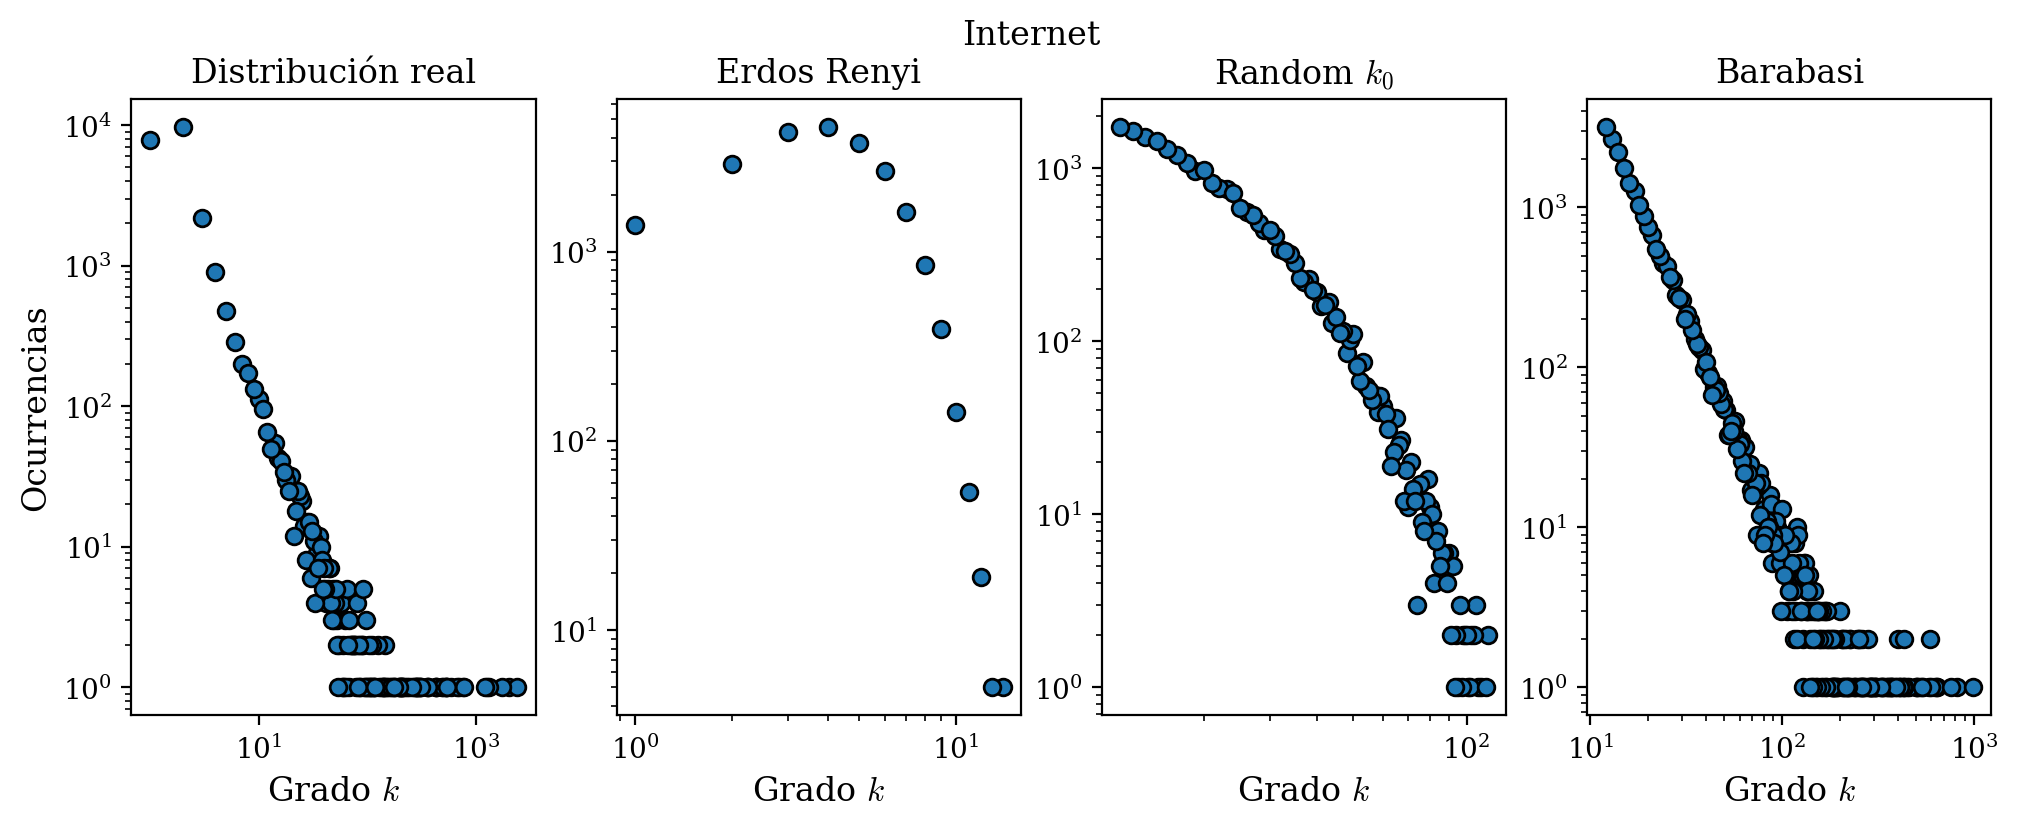

In [15]:
plot_random_distributions(dict_graph["Y2H"], k02 = 1, k03 = 2, suptitle="Y2H")
plot_random_distributions(dict_graph["Science"], k02 = 6, k03 = 5, suptitle="Science")
plot_random_distributions(dict_graph["Internet"], k02 = 12, k03 = 12, suptitle="Internet")

# Modelo configuracional

In [108]:
def poisson_degree_distribution(N, mean_degree) -> np.array:
    """
    Genera una distribucion de grados segun la distribucion de poisson.
    """
    d = np.random.poisson(mean_degree, N)
    if sum(d)%2 != 0:
        random_ix = np.random.randint(0, N, 1)
        d[random_ix]+=1
    return d

def configuration_model_graph(d, max_err_iters) -> nx.graph:
    """
    Genera un grafo aleatorio segun el "configurational model", a partir de una
    lista de la distribucion de grados de los nodos.
    max_err_iters es el numero maximo de iteraciones consecutivas en la cual
    el enlace elegido es repetido o autoenlace en el proceso de armado de enlaces.
    """
    N = len(d) #Numero de nodos
    nodes = np.arange(N) #Id's
    half_edges = [] #Inicializo la lista en la que guardo los medios enlaces.
    for n, d_i in zip(nodes, d):
        half_edges += [n]*d_i
    edges = [] #Aca guardo la lista de enlaces entre nodos, como tuplas
    half_edges_copy = half_edges.copy()
    error_count = 0 #Inicializo la variable que cuenta la cantidad de iteraciones en las que el enlace propuesto era repetido o un autoenlace.
    while len(half_edges_copy) != 0:
        n1, n2 = np.random.choice(half_edges_copy, 2)
        if n1 == n2 or (n1, n2) in edges or (n2, n1) in edges: #No quiero que sea un autoenlace o un enlace repetido
            error_count += 1
            if error_count > max_err_iters:
                ### Si los errores superan el umbral de tolerancia, reseteo las variables.
                edges = []
                half_edges_copy = half_edges.copy()
                error_count = 0
            continue
        else:
            ### Si todo anda bien, agrego el enlace propuesto, elimino los medios-enlaces de la lista y reseteo el error_count.
            edges += [(n1, n2)]
            half_edges_copy.remove(n1); half_edges_copy.remove(n2)
            error_count = 0 #Reset error count
    G = nx.Graph()
    G.add_edges_from(edges)
    G.add_nodes_from(nodes)
    return G


In [109]:
N = 10000; mean_degree = 2
d = poisson_degree_distribution(N, mean_degree)
G = configuration_model_graph(d, 10)

Utilizo la red de proteinas LIT, y comparo su coeficiente de clustering medio con el 
de la red aleatoria generada a partir del configuration model

In [110]:
path = '../TP1/datasets/LIT.txt'
df = pd.read_csv(path, delimiter="\t", header=None, names=["source", "target"])
# Cargamos todas las redes como grafos no dirigidos:
proteins = nx.from_pandas_edgelist(df, create_using=nx.Graph)
degree_dist = dict(proteins.degree()).values()
avg_C = nx.average_clustering(proteins)

try:
    with open("avg_C.list", "rb") as f:
        random_avg_C = pickle.load(f)
    
except FileNotFoundError:
    random_avg_C = []
    for i in tqdm(range(1000)):
        G = configuration_model_graph(degree_dist, 20)
        random_avg_C.append(nx.average_clustering(G))
    with open("avg_C.list", "wb") as f:
        pickle.dump(random_avg_C, f)

print(f"Coeficiente medio de clustering en LIT: {avg_C:.2f}\nCoeficiente medio de clustering en red aleatoria: {np.mean(random_avg_C):.4f} +-  {np.std(random_avg_C):.1g}")


100%|██████████| 1000/1000 [19:06<00:00,  1.15s/it]

Coeficiente medio de clustering en LIT: 0.29
Coeficiente medio de clustering en red aleatoria: 0.0062 +-  0.001


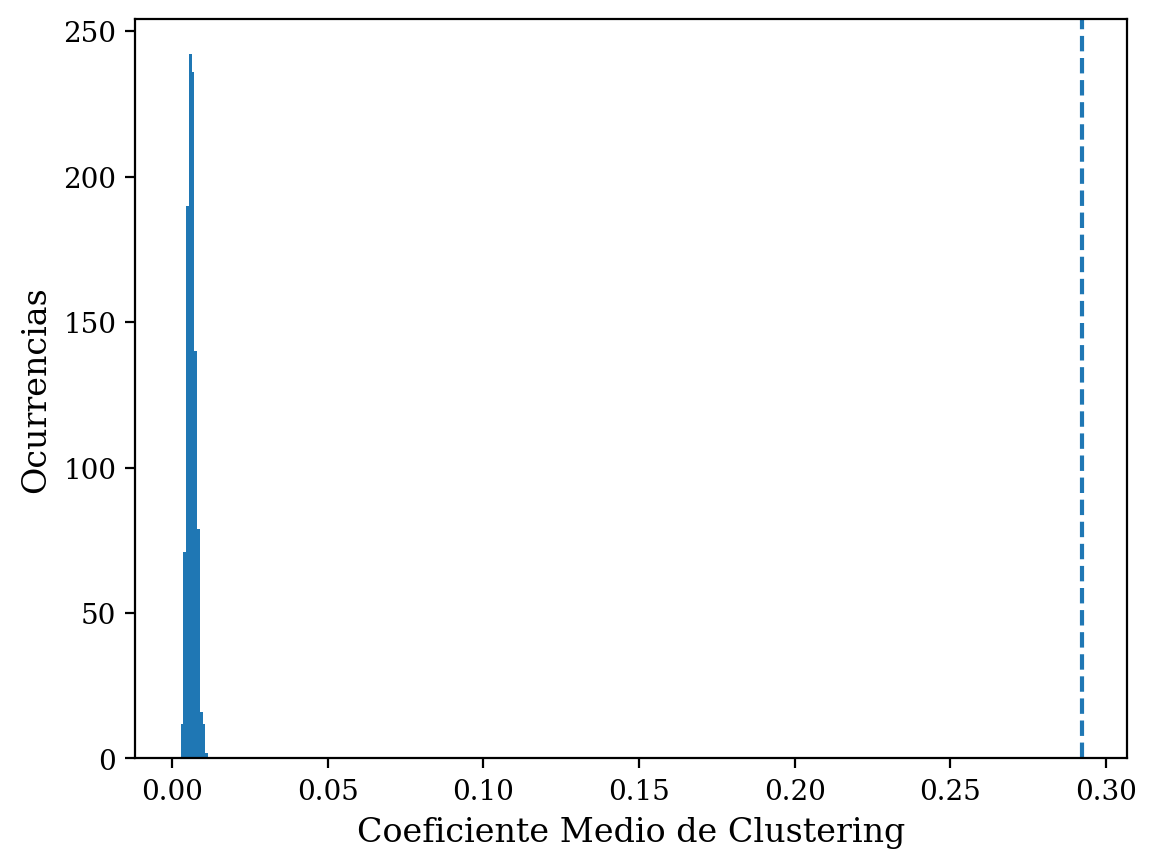

In [111]:
plt.hist(random_avg_C)
plt.xlabel("Coeficiente Medio de Clustering")
plt.ylabel("Ocurrencias")
plt.axvline(avg_C, ls="--")

Se observa que el coeficiente medio de clustering de la red de proteinas difiere significativamente del obtenido para redes aleatorias generadas con la misma distribucion de grado.